In [1]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.preprocessing import minmax_scale

In [2]:
sys.path.insert(0, '../modules/')
import cleaning as cln
import feature_eng as feng

## 1. Initial Data Preparation and Understanding

In [3]:
#Read the full data from 'train' and 'store' files:

full_df_train = pd.read_csv("../data/train.csv")
full_df_store = pd.read_csv("../data/store.csv")

/Users/sara/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
full_df_train.head()

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


In [5]:
full_df_store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
#Merge the train and store data frames:

full_df = cln.merge(full_df_train, full_df_store)

In [7]:
full_df.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
print("Total number of rows in full data set: ", full_df.shape[0])

Total number of rows in full data set:  637774


In [9]:
#Check if there are nulls in full data

full_df.isnull().any().any()

True

In [10]:
#Check which columns of full data have null values

full_df.isnull().any()

Date                         False
Store                         True
DayOfWeek                     True
Sales                         True
Customers                     True
Open                          True
Promo                         True
StateHoliday                  True
SchoolHoliday                 True
StoreType                     True
Assortment                    True
CompetitionDistance           True
CompetitionOpenSinceMonth     True
CompetitionOpenSinceYear      True
Promo2                        True
Promo2SinceWeek               True
Promo2SinceYear               True
PromoInterval                 True
dtype: bool

Column Date has  0% null values.
Column Store has  3% null values.
Column DayOfWeek has  3% null values.
Column Sales has  3% null values.
Column Customers has  3% null values.
Column Open has  3% null values.
Column Promo has  3% null values.
Column StateHoliday has  3% null values.
Column SchoolHoliday has  3% null values.
Column StoreType has  3% null values.
Column Assortment has  3% null values.
Column CompetitionDistance has  3% null values.
Column CompetitionOpenSinceMonth has  34% null values.
Column CompetitionOpenSinceYear has  34% null values.
Column Promo2 has  3% null values.
Column Promo2SinceWeek has  51% null values.
Column Promo2SinceYear has  51% null values.
Column PromoInterval has  51% null values.


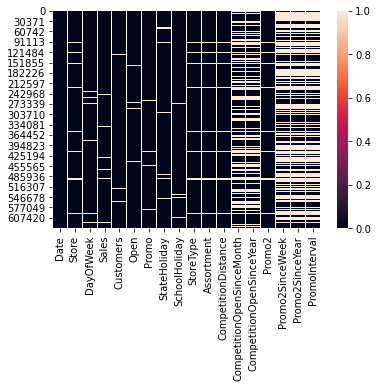

In [11]:
#Check the null values:

nulls = full_df.isnull()
sns.heatmap(nulls)

cln.count_null_features(full_df)

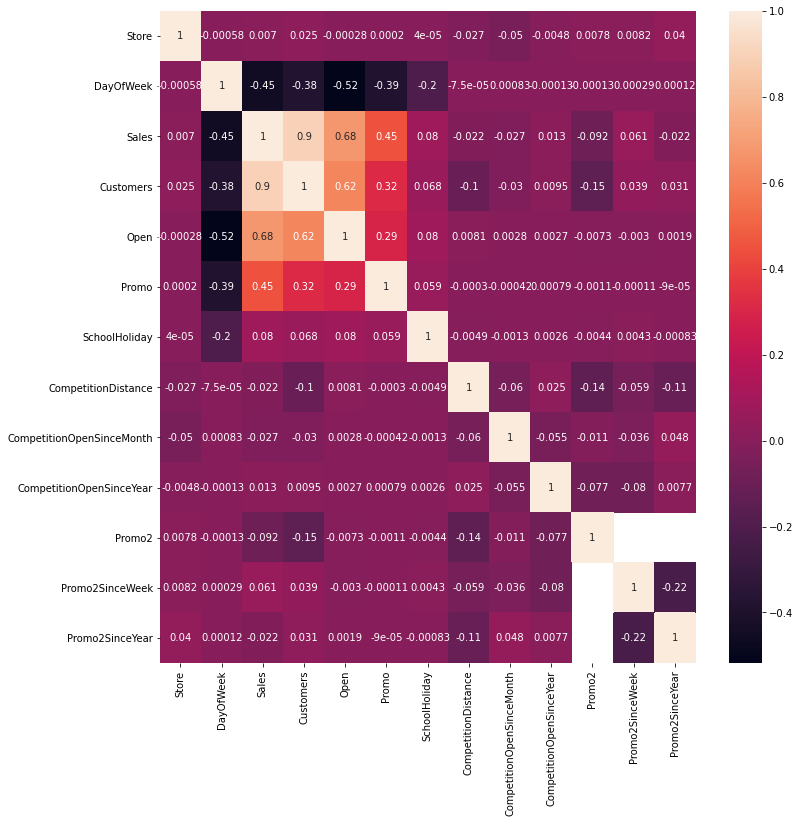

In [12]:
#Check the correlations

corrMatrix = full_df.corr()
fig = plt.figure(figsize=(12,12))
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [13]:
#Check the column with mixed types

full_df.loc[:, 'StateHoliday'].unique()

array(['a', nan, '0', 'b', 'c', 0.0], dtype=object)

In [14]:
print(f'Dates are from {full_df.Date.min()} to {full_df.Date.max()}')

Dates are from 2013-01-01 to 2014-07-31


In [15]:
daily_sales = full_df.groupby(by='Date').Sales.sum()

daily_sales

Date
2013-01-01      92200.0
2013-01-02    6788505.0
2013-01-03    6167913.0
2013-01-04    6462380.0
2013-01-05    5743875.0
                ...    
2014-07-27     242866.0
2014-07-28    8270451.0
2014-07-29    7139821.0
2014-07-30    7265673.0
2014-07-31    8092801.0
Name: Sales, Length: 577, dtype: float64

<AxesSubplot:xlabel='Date', ylabel='Sales'>

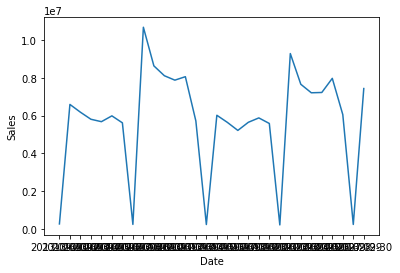

In [16]:
sns.lineplot(data=daily_sales.loc['2013-09-01':'2013-09-30'])

<AxesSubplot:xlabel='Date', ylabel='Sales'>

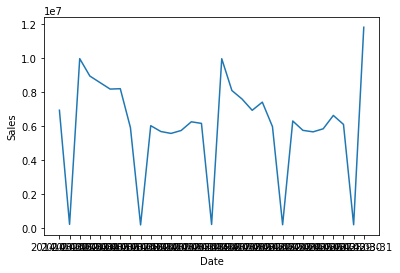

In [17]:
sns.lineplot(data=daily_sales.loc['2014-03-01':'2014-03-31'])

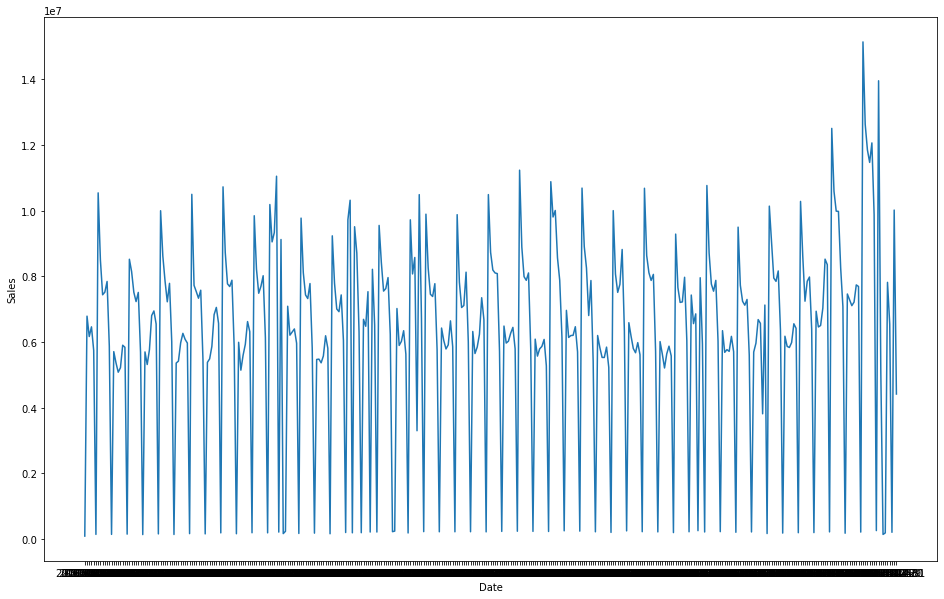

In [18]:
fig = plt.figure(figsize=(16,10))
sns.lineplot(data=daily_sales.loc['2013-01-01':'2013-12-31'])
plt.show()

## 2. Data Cleaning

In [19]:
#Remove the Cusomers column, as was instructed to us

clean_df = cln.drop_column(full_df, column='Customers')

clean_df.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [20]:
# We already saw there are null values in targt (Sales)
# Check for zero values in terget

zero_sales = clean_df[clean_df['Sales'] == 0]

zero_sales_and_closed = zero_sales.loc[zero_sales.loc[:, 'Open']==0]
print(f'zero sales reported when stores were closed: {zero_sales_and_closed.shape[0]/zero_sales.shape[0]}')

zero_sales_and_open = zero_sales.loc[zero_sales.loc[:, 'Open']==1]
print(f'zero sales reported when stores were open: {zero_sales_and_open.shape[0]/zero_sales.shape[0]}')

zero sales reported when stores were closed: 0.9696855120000756
zero sales reported when stores were open: 0.00037810399750451364


In [21]:
# Perform target cleaning
# All the rows with null and zero target values are dropped 

clean_df = cln.clean_targets(clean_df, target='Sales')
clean_df.shape

(531983, 17)

In [22]:
# Perform a rough feature cleaning

# Remove the rows with null feature values if number of null values are very small.
# Drop the whole feature column if number of null values are not small.
# The threshold is 10%.
# Transform the values in StateHoliday column: transform 0.0 to 0 and all column to string.
    
clean_df = cln.rough_features_cleaning(clean_df, threshold=0.10, drop_columns=True, verbose=True)

Total number of rows before cleaning:  531983
Column Date has  0% null values.
Column Store has  3% null values.
Removed rows with null value from Store.
Column DayOfWeek has  3% null values.
Removed rows with null value from DayOfWeek.
Column Sales has  3% null values.
Removed rows with null value from Sales.
Column Open has  3% null values.
Removed rows with null value from Open.
Column Promo has  3% null values.
Removed rows with null value from Promo.
Column StateHoliday has  3% null values.
Removed rows with null value from StateHoliday.
Column SchoolHoliday has  3% null values.
Removed rows with null value from SchoolHoliday.
Column StoreType has  0% null values.
Column Assortment has  0% null values.
Column CompetitionDistance has  0% null values.
Removed rows with null value from CompetitionDistance.
Column CompetitionOpenSinceMonth has  25% null values.
Dropped the column CompetitionOpenSinceMonth.
Column CompetitionOpenSinceYear has  25% null values.
Dropped the column Compet

In [23]:
#Check the StateHoliday values after cleaning:

clean_df.loc[:, 'StateHoliday'].unique()

array(['a', '0', 'b', 'c'], dtype=object)

Column Date has  0% null values.
Column Store has  0% null values.
Column DayOfWeek has  0% null values.
Column Sales has  0% null values.
Column Open has  0% null values.
Column Promo has  0% null values.
Column StateHoliday has  0% null values.
Column SchoolHoliday has  0% null values.
Column StoreType has  0% null values.
Column Assortment has  0% null values.
Column CompetitionDistance has  0% null values.
Column Promo2 has  0% null values.


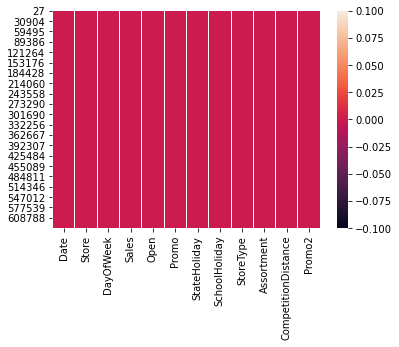

In [24]:
#Check the null values after cleaning:

nulls = clean_df.isnull()
sns.heatmap(nulls)

cln.count_null_features(clean_df)

In [25]:
clean_df.head()

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
27,2013-01-01,353.0,2.0,3139.0,1.0,0.0,a,1.0,b,b,900.0,1.0
115,2013-01-01,335.0,2.0,2401.0,1.0,0.0,a,1.0,b,a,90.0,1.0
147,2013-01-01,512.0,2.0,2646.0,1.0,0.0,a,1.0,b,b,590.0,1.0
162,2013-01-01,494.0,2.0,3113.0,1.0,0.0,a,1.0,b,a,1260.0,0.0
199,2013-01-01,530.0,2.0,2907.0,1.0,0.0,a,1.0,a,c,18160.0,0.0


In [26]:
clean_df.tail()

,Date,Store,DayOfWeek,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
637766,2014-07-31,748.0,4.0,7616.0,1.0,1.0,0,1.0,d,a,2380.0,1.0
637768,2014-07-31,743.0,4.0,4527.0,1.0,1.0,0,1.0,a,a,6710.0,1.0
637769,2014-07-31,752.0,4.0,7259.0,1.0,1.0,0,1.0,a,a,970.0,1.0
637772,2014-07-31,755.0,4.0,12302.0,1.0,1.0,0,1.0,d,c,13130.0,0.0
637773,2014-07-31,751.0,4.0,3913.0,1.0,1.0,0,1.0,a,a,650.0,0.0


In [27]:
clean_df.isna().any().any()

False

In [28]:
clean_df.isnull().any().any()

False

In [29]:
clean_df.Open.unique()

array([1.])

In [30]:
# Remove the Open column because its values are all 1

clean_df = cln.drop_column(clean_df, column='Open')

In [31]:
clean_df.head()

,Date,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
27,2013-01-01,353.0,2.0,3139.0,0.0,a,1.0,b,b,900.0,1.0
115,2013-01-01,335.0,2.0,2401.0,0.0,a,1.0,b,a,90.0,1.0
147,2013-01-01,512.0,2.0,2646.0,0.0,a,1.0,b,b,590.0,1.0
162,2013-01-01,494.0,2.0,3113.0,0.0,a,1.0,b,a,1260.0,0.0
199,2013-01-01,530.0,2.0,2907.0,0.0,a,1.0,a,c,18160.0,0.0


## 3. Split Data to Training and Cross Validation sets and Feature Engineering

Some feature engineering (make new date features, one_hot_encoding, etc.) has done before the split of data, and some after (mean encoding, feature normalisation) 

In [32]:
# Make new date features, before split into training and cross validation sets

clean_df = feng.dates_features(clean_df)

In [33]:
clean_df.columns

Index(['Date', 'Store', 'Sales', 'Promo', 'StateHoliday', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance', 'Promo2', 'month',
       'day_of_week', 'day_of_month', 'is_monday', 'is_saturday'],
      dtype='object')

In [34]:
# Add one hot encoding of StateHoliday, StoreType, Assortment before split

clean_df = feng.one_hot_encoding(clean_df, 'StateHoliday')
clean_df = feng.one_hot_encoding(clean_df, 'StoreType')
clean_df = feng.one_hot_encoding(clean_df, 'Assortment')

In [35]:
clean_df.head()

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _a,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c
27,2013-01-01,353.0,3139.0,0.0,1.0,900.0,1.0,1,1,1,...,1,0,0,0,1,0,0,0,1,0
115,2013-01-01,335.0,2401.0,0.0,1.0,90.0,1.0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
147,2013-01-01,512.0,2646.0,0.0,1.0,590.0,1.0,1,1,1,...,1,0,0,0,1,0,0,0,1,0
162,2013-01-01,494.0,3113.0,0.0,1.0,1260.0,0.0,1,1,1,...,1,0,0,0,1,0,0,1,0,0
199,2013-01-01,530.0,2907.0,0.0,1.0,18160.0,0.0,1,1,1,...,1,0,0,1,0,0,0,0,0,1


In [36]:
clean_df.columns

Index(['Date', 'Store', 'Sales', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'Promo2', 'month', 'day_of_week', 'day_of_month',
       'is_monday', 'is_saturday', 'StateHoliday _0', 'StateHoliday _a',
       'StateHoliday _b', 'StateHoliday _c', 'StoreType _a', 'StoreType _b',
       'StoreType _c', 'StoreType _d', 'Assortment _a', 'Assortment _b',
       'Assortment _c'],
      dtype='object')

In [37]:
# Split the data into training and cross validation sets

df_train, df_test = feng.date_split_train_test(clean_df, '2014-05-01')

In [38]:
df_train.head(1)

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _a,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c
27,2013-01-01,353.0,3139.0,0.0,1.0,900.0,1.0,1,1,1,...,1,0,0,0,1,0,0,0,1,0


In [39]:
df_train.tail(1)

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _a,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c
540773,2014-04-30,741.0,12208.0,1.0,0.0,11900.0,0.0,4,2,30,...,0,0,0,0,0,0,1,0,0,1


In [40]:
df_test.head(1)

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _a,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c
540889,2014-05-01,335.0,10770.0,1.0,0.0,90.0,1.0,5,3,1,...,1,0,0,0,1,0,0,1,0,0


In [41]:
df_test.tail(1)

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _a,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c
637773,2014-07-31,751.0,3913.0,1.0,1.0,650.0,0.0,7,3,31,...,0,0,0,1,0,0,0,1,0,0


In [42]:
df_train.shape

(361604, 23)

In [43]:
df_test.shape

(64085, 23)

In [44]:
#Add mean encoding for the Store id for train data

df_train, dict_store_values = feng.mean_encoding(df_train, 'Store')

In [45]:
df_train.head(1)

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c,Store_mean_encoded
27,2013-01-01,353.0,3139.0,0.0,1.0,900.0,1.0,1,1,1,...,0,0,0,1,0,0,0,1,0,4975.040107


In [46]:
#Apply same transformation to cross validation with the values from train set

df_test.loc[:, 'Store_mean_encoded'] = df_test.loc[:, 'Store'].replace(to_replace=dict_store_values)

/Users/sara/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/sara/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [47]:
df_test.loc[df_test.loc[:, 'Store'] == 353.0].head(1) 

,Date,Store,Sales,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,...,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c,Store_mean_encoded
541916,2014-05-02,353.0,5828.0,1.0,0.0,900.0,1.0,5,4,2,...,0,0,0,1,0,0,0,1,0,4975.040107


In [48]:
# Remove Store columns from data sets

df_train = df_train.drop('Store', axis=1)
df_test = df_test.drop('Store', axis=1)

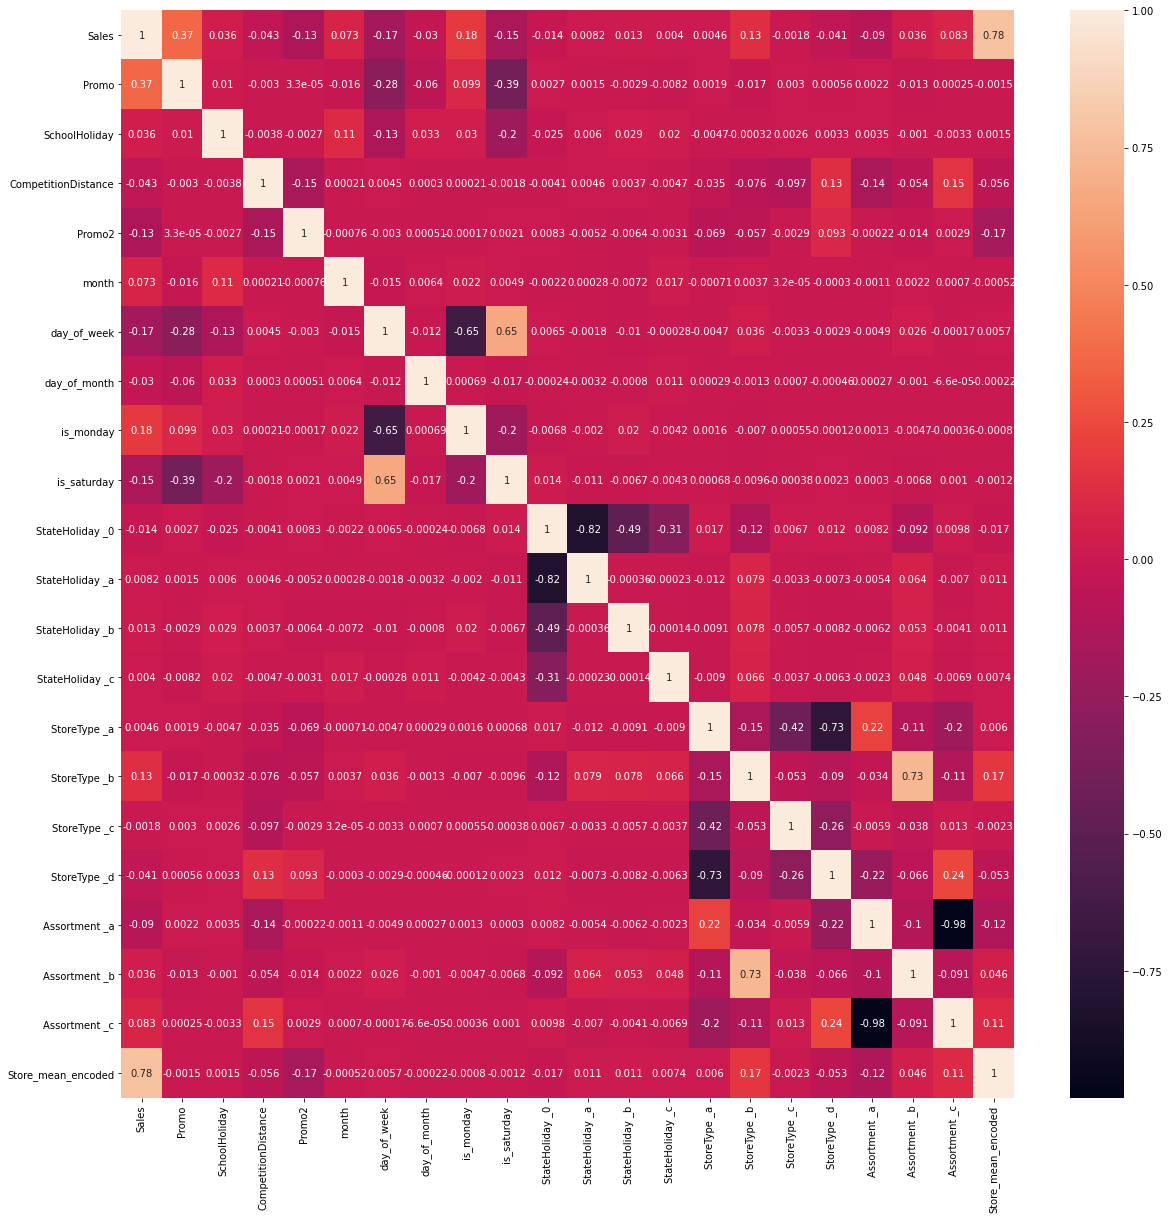

In [49]:
#Check the correlations, to help with feature selection

corrMatrix = df_train.corr()
fig = plt.figure(figsize=(20,20))
sns.heatmap(corrMatrix, annot=True)
plt.show()

## 4. Modeling

In [50]:
#Models are evaluated on the root mean square percentage error (RMSPE)

def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

### 4.1. Baseline

#### Simple mean

In [51]:
# Actual value: from test set
# Prediction: Mean sales of the store taken from train set

actuals = df_test.Sales.to_numpy()
preds_baseline = df_test.Store_mean_encoded.to_numpy()

print(f'Baseline Model RMSPE = {metric(preds_baseline, actuals):.2f}%')

Baseline Model RMSPE = 31.68%


### 4.2. Random Forest

In [52]:
# Features and targets:

X_train = df_train.drop(['Date','Sales'], axis=1)
y_train = df_train.loc[:, 'Sales']

X_test = df_test.drop(['Date','Sales'], axis=1)
y_test = df_test.loc[:, 'Sales']

In [53]:
X_train.head(1)

,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,is_monday,is_saturday,StateHoliday _0,...,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c,Store_mean_encoded
27,0.0,1.0,900.0,1.0,1,1,1,0,0,0,...,0,0,0,1,0,0,0,1,0,4975.040107


In [54]:
X_test.head(1)

,Promo,SchoolHoliday,CompetitionDistance,Promo2,month,day_of_week,day_of_month,is_monday,is_saturday,StateHoliday _0,...,StateHoliday _b,StateHoliday _c,StoreType _a,StoreType _b,StoreType _c,StoreType _d,Assortment _a,Assortment _b,Assortment _c,Store_mean_encoded
540889,1.0,0.0,90.0,1.0,5,3,1,0,0,0,...,0,0,0,1,0,0,1,0,0,13029.339286


In [55]:
# Random forest model initialisation

model_rf = RandomForestRegressor(n_estimators=100, max_depth=5)

In [56]:
# Fit and predict

model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)

In [57]:
# Evaluate

print(f'Random Forest Model RMSPE = {metric(preds_rf, actuals):.2f}%')

Random Forest Model RMSPE = 22.59%


### 4.3. XGBoost tree

In [58]:
# XGBoost model initialisation

model_xgb = xgboost.XGBRegressor()

In [59]:
# Fit and predict

model_xgb.fit(X_train, y_train)
preds_xgb = model_xgb.predict(X_test)

[00:34:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [60]:
# Evaluate

print(f'XGBoost Model RMSPE = {metric(preds_xgb, actuals):.2f}%')

XGBoost Model RMSPE = 20.52%


### 4.3. Multivariate Linear Regression

In [71]:
# ToDo: normalise features in train set

In [64]:
# Linear Regression model initialisation

model_regr = linear_model.LinearRegression()

In [65]:
# Fit and predict

model_regr.fit(X_train, y_train)
preds_regr = model_regr.predict(X_test)

In [66]:
# Evaluate

print(f'Linear Regression Model RMSPE = {metric(preds_regr, actuals):.2f}%')

Linear Regression Model RMSPE = 23.16%
